In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

np.random.seed(42)

In [2]:
wires = 6
dev = qml.device("default.qubit", wires=wires, shots=10000)

In [3]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return qml.probs(wires=range(wires))

def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return [qml.probs(wires=i) for i in range(wires)]

global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")

local_circuit = qml.QNode(local_cost_simple, dev, interface="autograd")

def cost_local(rotations):
    return 1 - np.sum(local_circuit(rotations)[:,0])/wires


def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

In [4]:
RX = np.random.uniform(low=-np.pi, high=np.pi)
RY = np.random.uniform(low=-np.pi, high=np.pi)
rotations = [[RX for i in range(wires)], [RY for i in range(wires)]]

Global Cost:  0.9733000
Local Cost:  0.4593667


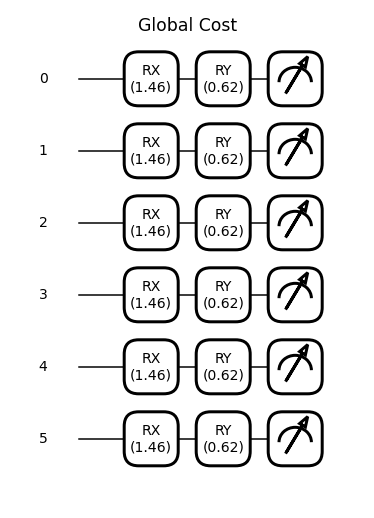

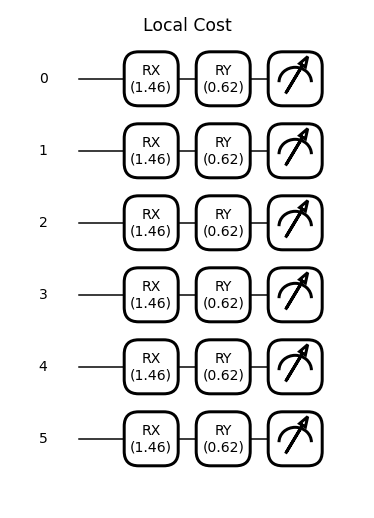

In [6]:
print("Global Cost: {: .7f}".format(cost_global(rotations)))
print("Local Cost: {: .7f}".format(cost_local(rotations)))

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(global_circuit, decimals=2)(rotations)
fig1.suptitle("Global Cost", fontsize='xx-large')
plt.show()

fig2, ax2 = qml.draw_mpl(local_circuit, decimals=2)(rotations)
fig2.suptitle("Local Cost", fontsize='xx-large')
plt.show()

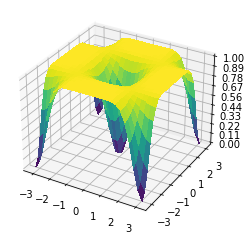

In [7]:
def generate_surface(cost_function):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)

    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = [[x for i in range(wires)], [y for i in range(wires)]]
            Z_assembler.append(cost_function(rotations))
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z

def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, surface, cmap="viridis", linewidth=0, antialiased=False)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()


global_surface = generate_surface(cost_global)
plot_surface(global_surface)